In [1]:
import warnings
warnings.filterwarnings("ignore")
#read the dataset
import pandas as pd
df = pd.read_csv("childcarecosts.csv", header=[0])

#Replace header with first row
new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header 

df

,Year,Age Group,Child Care Facility,Provider Rate
1,2000,Infants,Family Child Care Homes,477
2,2000,Infants,Licensed Center,631
3,2000,Toddler,Family Child Care Homes,444
4,2000,Toddler,Licensed Center,540
5,2000,Preschool,Family Child Care Homes,425
...,...,...,...,...
156,2019,Toddler,Licensed Center,1040
157,2019,Preschool,Family Child Care Homes,758
158,2019,Preschool,Licensed Center,923
159,2019,School Age,Family Child Care Homes,433


In [2]:
#convert date column strings to datetime objects
df['Year'] = pd.to_datetime(df['Year']).dt.date
df

,Year,Age Group,Child Care Facility,Provider Rate
1,2000-01-01,Infants,Family Child Care Homes,477
2,2000-01-01,Infants,Licensed Center,631
3,2000-01-01,Toddler,Family Child Care Homes,444
4,2000-01-01,Toddler,Licensed Center,540
5,2000-01-01,Preschool,Family Child Care Homes,425
...,...,...,...,...
156,2019-01-01,Toddler,Licensed Center,1040
157,2019-01-01,Preschool,Family Child Care Homes,758
158,2019-01-01,Preschool,Licensed Center,923
159,2019-01-01,School Age,Family Child Care Homes,433


In [3]:
#convert Provider Rate column strings to floats
for i in range(df.shape[0]):
    rev = df.iloc[i,3]
    rev1 = float(rev)
    
    df.iloc[i,3] = rev1

In [4]:
#counting for each website
df.groupby("Child Care Facility").count()

,Year,Age Group,Provider Rate
Child Care Facility,,,
Family Child Care Homes,80,80,80
Licensed Center,80,80,80


In [5]:
#picking out Infants in FCCH
sortedf = df.sort_values(by=['Age Group', "Child Care Facility"])

infantsfcch = sortedf.iloc[0:20,]
infantsfcch = infantsfcch.sort_values(by='Year')
infantsfcch

,Year,Age Group,Child Care Facility,Provider Rate
1,2000-01-01,Infants,Family Child Care Homes,477.0
9,2001-01-01,Infants,Family Child Care Homes,498.0
17,2002-01-01,Infants,Family Child Care Homes,542.0
25,2003-01-01,Infants,Family Child Care Homes,542.0
33,2004-01-01,Infants,Family Child Care Homes,542.0
41,2005-01-01,Infants,Family Child Care Homes,542.0
49,2006-01-01,Infants,Family Child Care Homes,587.0
57,2007-01-01,Infants,Family Child Care Homes,607.0
65,2008-01-01,Infants,Family Child Care Homes,650.0
73,2009-01-01,Infants,Family Child Care Homes,650.0


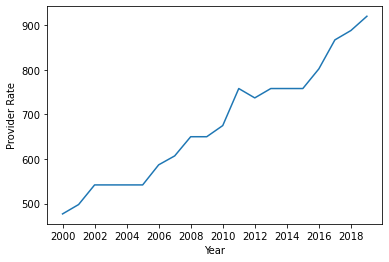

In [11]:
#Plotting Costs over time
from matplotlib import pyplot as plt
plt.plot(infantsfcch.iloc[:,0], infantsfcch.iloc[:,3])
plt.xlabel('Year')
plt.ylabel('Provider Rate')
plt.show()

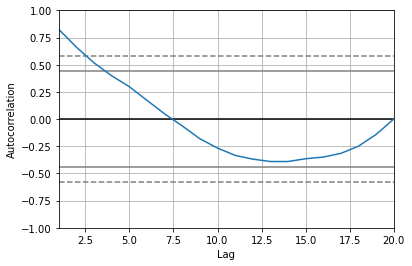

In [13]:
#autocorrelation plot of the time series
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(infantsfcch.iloc[:,3])
plt.show()

In [14]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
infantsfcchlist = infantsfcch.drop(['Age Group', 'Child Care Facility'], axis=1)
infantsfcchlist.head()

,Year,Provider Rate
1,2000-01-01,477.0
9,2001-01-01,498.0
17,2002-01-01,542.0
25,2003-01-01,542.0
33,2004-01-01,542.0


In [15]:
#rounding up floats
revlist = infantsfcchlist.iloc[:,1]
rrevlist = []
for i in revlist:
    rrevlist.append(round(i))
    
infantsfcchlist.iloc[:,1] = rrevlist
ifccs = infantsfcchlist.groupby("Year").sum()
ifccs.head()

,Provider Rate
Year,
2000-01-01,477
2001-01-01,498
2002-01-01,542
2003-01-01,542
2004-01-01,542


In [16]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Provider Rate'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

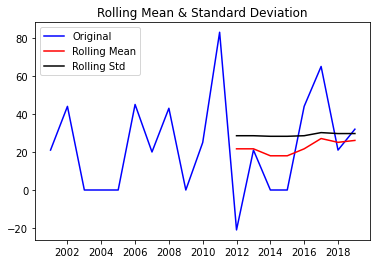

ADF Statistic: -4.765844667563523
p-value: 6.318669946506657e-05
Critical Values:
	1%: -3.859073285322359
	5%: -3.0420456927297668
	10%: -2.6609064197530863


In [17]:
#Test to check if time series is stationary
rates_log_shift = ifccs - ifccs.shift()
rates_log_shift.dropna(inplace=True)
get_stationarity(rates_log_shift)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


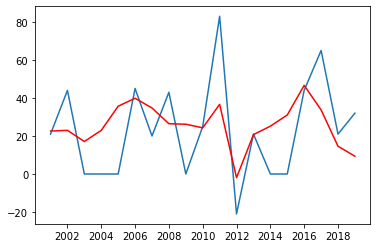

In [18]:
#Fitting the AutoRegressive Integrated Moving Average Model
model = ARIMA(ifccs, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(rates_log_shift)
plt.plot(results.fittedvalues, color='red')

In [19]:
#ARIMA predictions
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ifccs['Provider Rate'].iloc[0], index=dflist.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ifccs)
plt.plot(predictions_ARIMA)


NameError: name 'dflist' is not defined

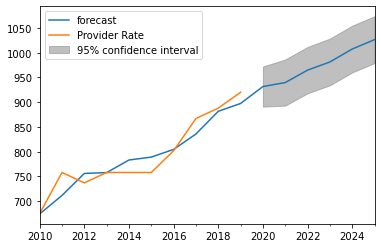

In [24]:
results.plot_predict(10,25)
cccpredlist = results.predict(19,25)

In [25]:
cccpredlist

2019-01-01     9.376234
2020-01-01    11.572375
2021-01-01     8.032767
2022-01-01    25.114611
2023-01-01    16.480147
2024-01-01    26.141170
2025-01-01    18.960612
Freq: AS-JAN, dtype: float64